In [1]:
# Import dependencies
%matplotlib inline
import os
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import seaborn as sns
import anndata
import matplotlib.pyplot as plt
import yaml
import scvi
import ray
import hyperopt
from ray import tune
from scvi import autotune

# Print date and time:
import datetime
e = datetime.datetime.now()
print ("Current date and time = %s" % e)

# Set other settings
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packag

Current date and time = 2024-08-29 11:56:09.180473
-----
anndata     0.9.1
scanpy      1.9.3
-----
PIL                         9.4.0
absl                        NA
aiohttp                     3.9.5
aiosignal                   1.3.1
annotated_types             0.5.0
anyio                       NA
arrow                       1.2.3
asttokens                   NA
async_timeout               4.0.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.14.0
backcall                    0.2.0
backoff                     2.2.1
brotli                      NA
bs4                         4.12.2
certifi                     2024.07.04
cffi                        1.15.1
charset_normalizer          3.2.0
chex                        0.1.83
click                       8.1.5
cloudpickle                 3.0.0
colorama                    0.4.6
comm                        0.1.3
contextlib2                 NA
croniter                    NA
cycler                  

In [2]:
# set a working directory
wdir = '/media/prom/apc1/ccohen/chromium/analysis/20240711_Achilles'
os.chdir( wdir )

# create an output directory with today's date and time
year = e.strftime("%Y")
month = e.strftime("%m")
day = e.strftime("%d")
hour = e.strftime('%H')
minute = e.strftime('%M')
dmyt = f'{year}{month}{day}_{hour}-{minute}'
directory = f'{dmyt}_integration-scvi.dir'

# folder structures
RESULTS_FOLDERNAME = f'{directory}/results/'
FIGURES_FOLDERNAME = f'{directory}/figures/'

if not os.path.exists(RESULTS_FOLDERNAME):
    os.makedirs(RESULTS_FOLDERNAME)
if not os.path.exists(FIGURES_FOLDERNAME):
    os.makedirs(FIGURES_FOLDERNAME)
    
# Set folder for saving figures into
sc.settings.figdir = FIGURES_FOLDERNAME

print(directory)

20240829_11-56_integration-scvi.dir


In [3]:
# Read in the yml file
ini = yaml.safe_load(open('integration-scvi.yaml'))
print(yaml.safe_dump(ini))

datadir: 20240828_10-23_concat_norm.dir
neighbours:
  n_pcs: 30
variable_genes:
  batch: patient.seqbatch
  flavor: seurat
  hvg_subset: true
  n_genes: 5000



Read in the concatenated object.
In the concat_norm script, normalisation and dim reduction was performed but this is not actually needed here because we will start again from the raw counts. 
The only question is whether to work on the whole object or to subset to hvg (and if so how many)

In [4]:
wdir

'/media/prom/apc1/ccohen/chromium/analysis/20240711_Achilles'

In [5]:
# path = os.path.join(wdir, 'concat_norm/results/merged_normalised.h5ad')
# For testing use the subsetted object with only 3 samples in it
path = os.path.join(wdir, ini['datadir'], 'results/merged_normalised.h5ad')
path

'/media/prom/apc1/ccohen/chromium/analysis/20240711_Achilles/20240828_10-23_concat_norm.dir/results/merged_normalised.h5ad'

In [6]:
# This will be the unintegrated reference data
# NB for some integration methods, here the data is subsetted to only hvg (see Alina's tutorial)
adata_ref = sc.read_h5ad(path)
adata_ref

AnnData object with n_obs × n_vars = 69476 × 61552
    obs: 'sample', 'sum', 'detected', 'subsets_mito_percent', 'total', 'log10GenesPerUMI', 'patient', 'age', 'sex', 'ethnicity', 'surgical_procedure', 'disease_status', 'anatomical_site', 'affected_side', 'time_to_freezing', 'sequencing_date', 'microanatomical_site', 'seurat_clusters', 'decontX_contamination', 'sizeFactor', 'scDblFinder.class', 'patient.seqbatch'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'log1p', 'microanatomical_site_colors', 'neighbors', 'patient_colors', 'pca', 'sample_colors', 'sequencing_date_colors', 'sex_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'decontX', 'log1p_norm', 'scaled', 'soupX'
    obsp: 'connectivities', 'distances'

In [7]:
# subset to decontX <0.3
adata_ref = adata_ref[adata_ref.obs['decontX_contamination'] < 0.3,:].copy()
adata_ref

AnnData object with n_obs × n_vars = 67668 × 61552
    obs: 'sample', 'sum', 'detected', 'subsets_mito_percent', 'total', 'log10GenesPerUMI', 'patient', 'age', 'sex', 'ethnicity', 'surgical_procedure', 'disease_status', 'anatomical_site', 'affected_side', 'time_to_freezing', 'sequencing_date', 'microanatomical_site', 'seurat_clusters', 'decontX_contamination', 'sizeFactor', 'scDblFinder.class', 'patient.seqbatch'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'log1p', 'microanatomical_site_colors', 'neighbors', 'patient_colors', 'pca', 'sample_colors', 'sequencing_date_colors', 'sex_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'decontX', 'log1p_norm', 'scaled', 'soupX'
    obsp: 'connectivities', 'distances'

In [8]:
# scvi works with raw counts
adata_ref.X = adata_ref.layers['counts'].copy()

In [9]:
# make a new object to perform the integration
adata_scvi = adata_ref.copy()


In [10]:
# take a snapshot
adata_scvi.raw = adata_scvi

In [11]:
# subset to hvg if required
if ini['variable_genes']['hvg_subset'] == True: 
    adata_scvi = adata_scvi[:, adata_scvi.var.highly_variable].copy()
    
adata_scvi

AnnData object with n_obs × n_vars = 67668 × 7000
    obs: 'sample', 'sum', 'detected', 'subsets_mito_percent', 'total', 'log10GenesPerUMI', 'patient', 'age', 'sex', 'ethnicity', 'surgical_procedure', 'disease_status', 'anatomical_site', 'affected_side', 'time_to_freezing', 'sequencing_date', 'microanatomical_site', 'seurat_clusters', 'decontX_contamination', 'sizeFactor', 'scDblFinder.class', 'patient.seqbatch'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'hvg', 'log1p', 'microanatomical_site_colors', 'neighbors', 'patient_colors', 'pca', 'sample_colors', 'sequencing_date_colors', 'sex_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'decontX', 'log1p_norm', 'scaled', 'soupX'
    obsp: 'connectivities', 'distances'

In [12]:
# set up the adata object
scvi.model.SCVI.setup_anndata(adata_scvi,
                              layer = 'counts',
                              batch_key = "patient.seqbatch"
                             )

Set up the scVI model using optimised hyperparameters:
Result(
  metrics={'validation_loss': 1018.7122192382812},
  path='/media/prom/apc1/ccohen/chromium/analysis/20240711_Achilles/ray/tune_scvi_2024-07-26-10:50:07/_trainable_29df8f7f_64_gene_likelihood=zinb,lr=0.0023,n_hidden=60,n_latent=30,n_layers=1_2024-07-26_10-50-41',
  filesystem='local',
  checkpoint=None
)

In [13]:
# set up the scVI model
# specify the parameters according to the ray optimisation
vae = scvi.model.SCVI(adata_scvi,
                      n_latent = 30,  
                      n_hidden = 256, 
                      n_layers =  1, 
                      dropout_rate = 0.1,
                      dispersion = 'gene-batch',
                     gene_likelihood='zinb')

vae

SCVI Model with the following params: 
n_hidden: 256, n_latent: 30, n_layers: 1, dropout_rate: 0.1, dispersion: gene-batch, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

In [14]:
# add the parameter for lr
kwargs = {'lr': 0.001427}

In [15]:
 vae.view_anndata_setup(adata_scvi) # check the set up looks as expected

Anndata setup with scvi-tools version 1.0.2.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'patient.seqbatch',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   8   │
│         n_cells          │ 67668 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 7000  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                           batch State Registry                           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['patient.seqbatch'] │ MSK0785_11102021 │          0          │
│                               │ MSK1250_11102021 │          1          │
│                               │ MSK1250_20230822 │          2          │
│                               │ MSK1284_11102021 │          3          │
│                               │ MSK1556_20220808 │          4          │
│                               │ MSK1556_20230822 │          5          │
│                               │ MSK1687_20230822 │          6          │
│                               │ MSK1691_20230822 │          7          │
└───────────────────────────────┴──────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [16]:
# calculate the number of epochs needed which varies according to the cell number
max_epochs_scvi = int(np.min([round((20000 / adata_ref.n_obs) * 400), 400])) # must be an integer
max_epochs_scvi

118

In [17]:
# run the training (need the GPU queue here)
# updated to 60 epochs due to overfitting
vae.train(max_epochs = max_epochs_scvi, 
          train_size = 0.9, 
          validation_size = 0.1, 
          accelerator='gpu', 
          check_val_every_n_epoch=1,
          early_stopping=True,
          early_stopping_patience=10,
          early_stopping_monitor="elbo_validation",
          plan_kwargs = kwargs
         )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 118/118: 100%|█| 118/118 [05:08<00:00,  2.59s/it, v_num=1, train_loss_step

`Trainer.fit` stopped: `max_epochs=118` reached.


Epoch 118/118: 100%|█| 118/118 [05:08<00:00,  2.61s/it, v_num=1, train_loss_step


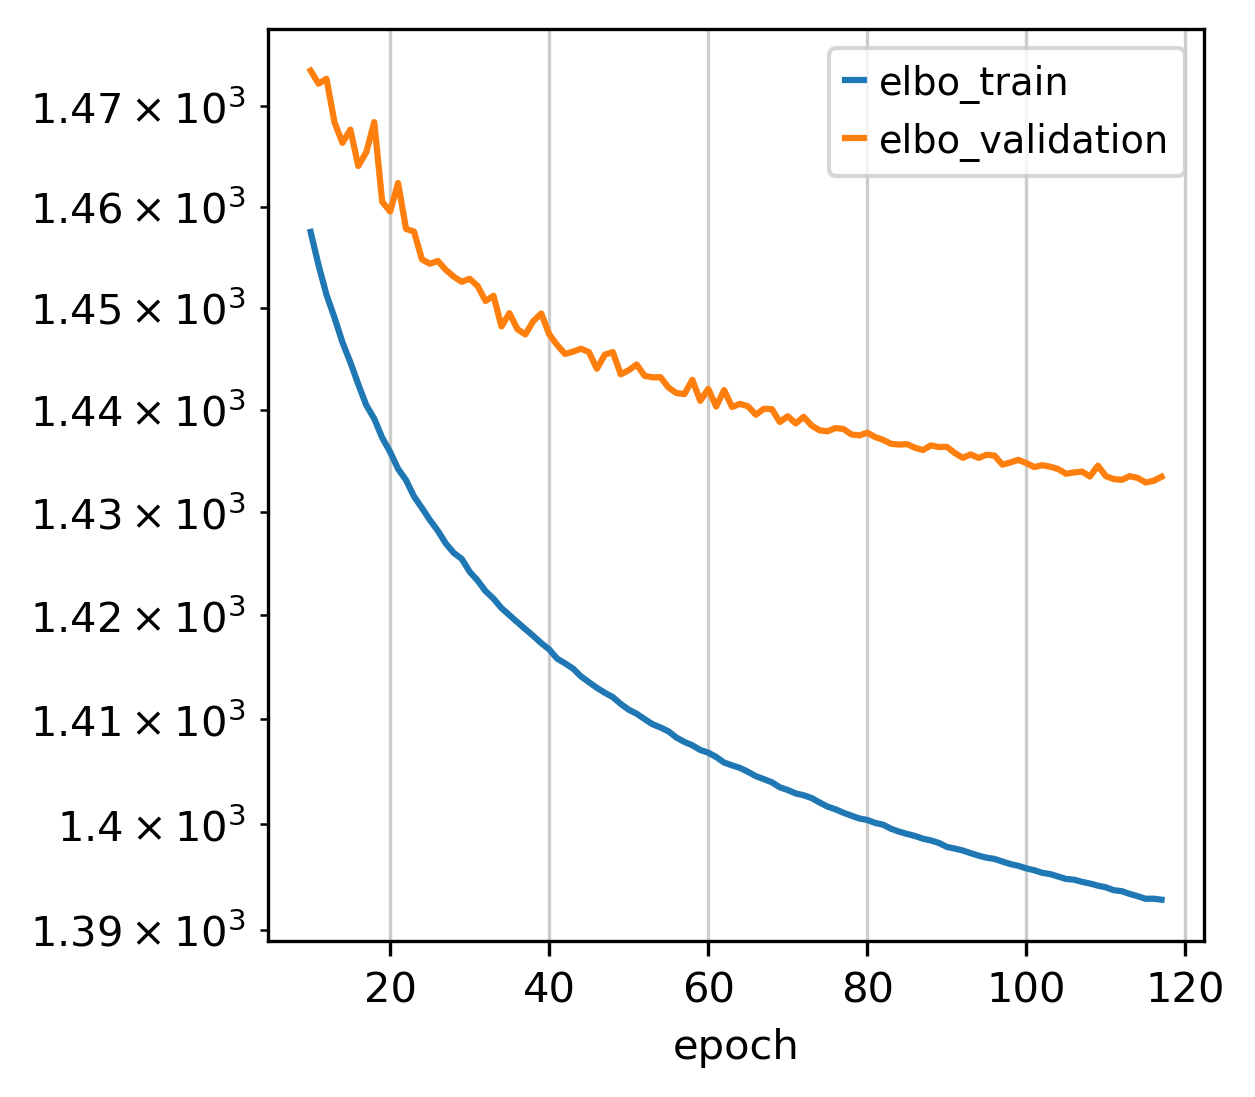

In [18]:
# visualise the results of the training
train_test_results = vae.history["elbo_train"]
train_test_results["elbo_validation"] = vae.history["elbo_validation"]
train_test_results.iloc[10:].plot(logy=True)  # exclude first 10 epochs
plt.show()


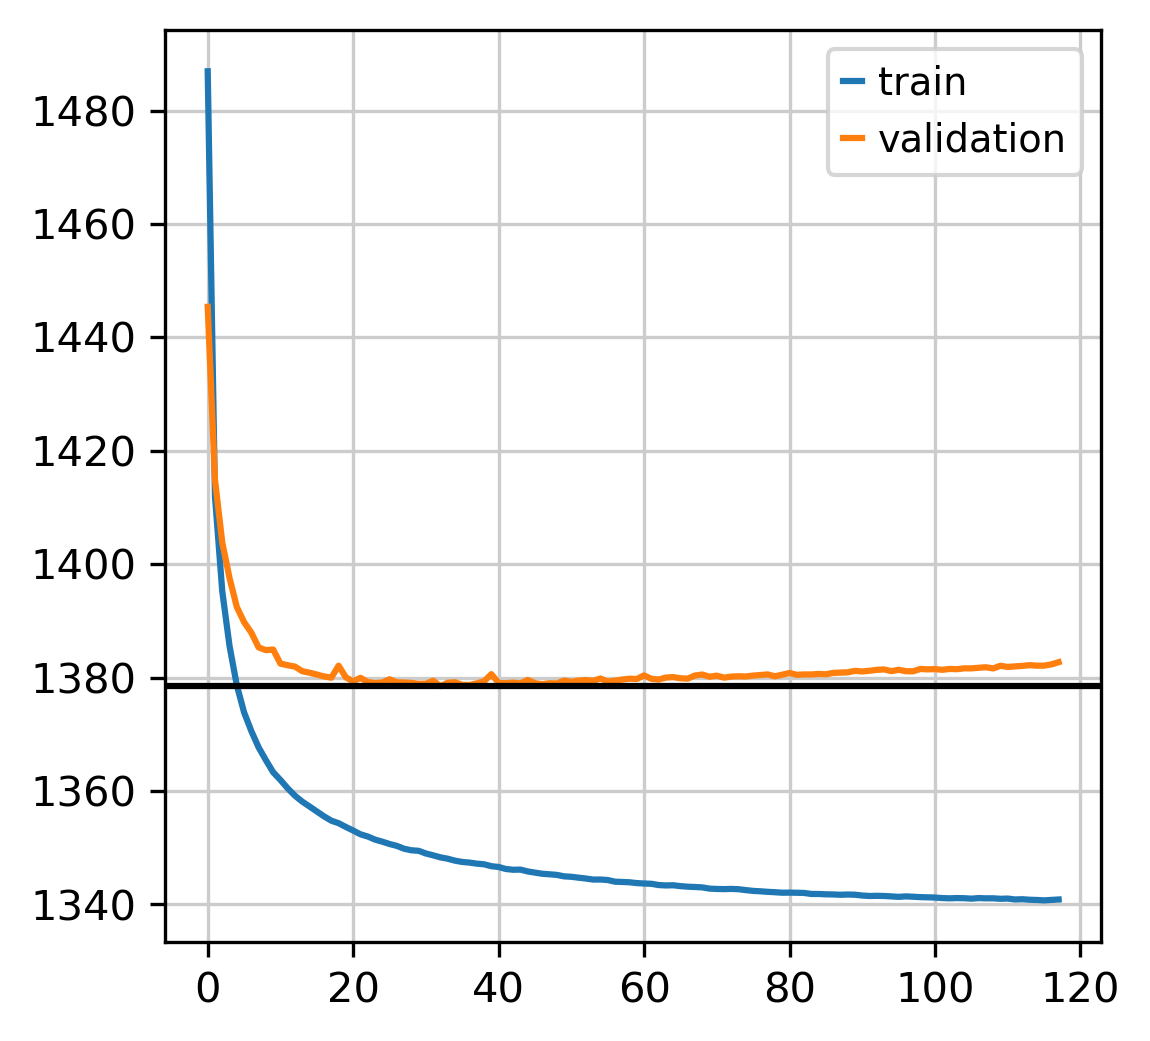

In [19]:
y = vae.history['reconstruction_loss_validation']['reconstruction_loss_validation'].min()
plt.plot(vae.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train')
plt.plot(vae.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label='validation')
plt.axhline(y, c = 'k')
plt.legend()
plt.show()

In [20]:
# save the trained model
# in file name use: sample, covariate, nepochs, n_hidden, n_latent, n_layers, dropout rate, dispersion, gene likelihood
vae.save(os.path.join(RESULTS_FOLDERNAME, "Ach_patient.seqbach_60_256_50_1_01_gene-batch_zinb/"), overwrite=True)

computing neighbors


/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/media/prom/apc1

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:28)


/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


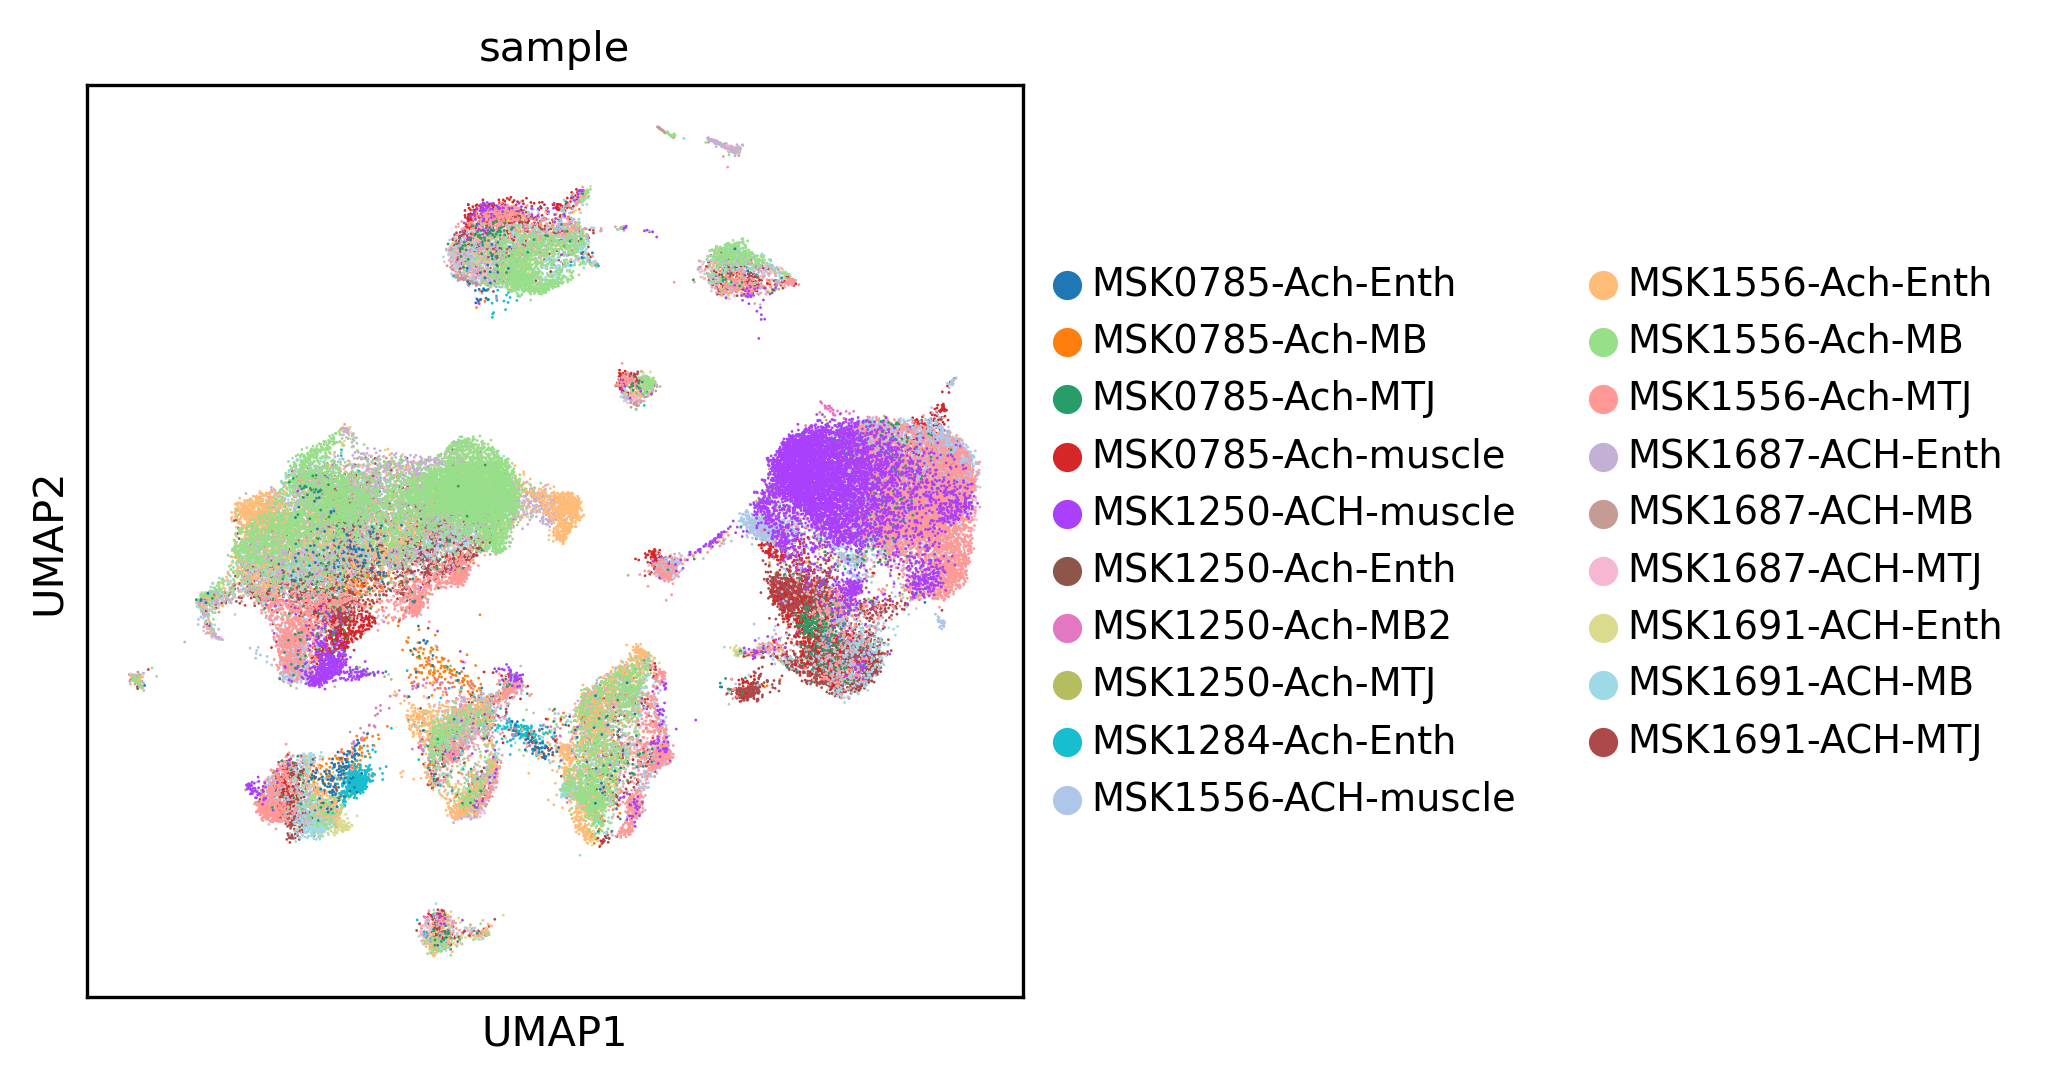

/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the 

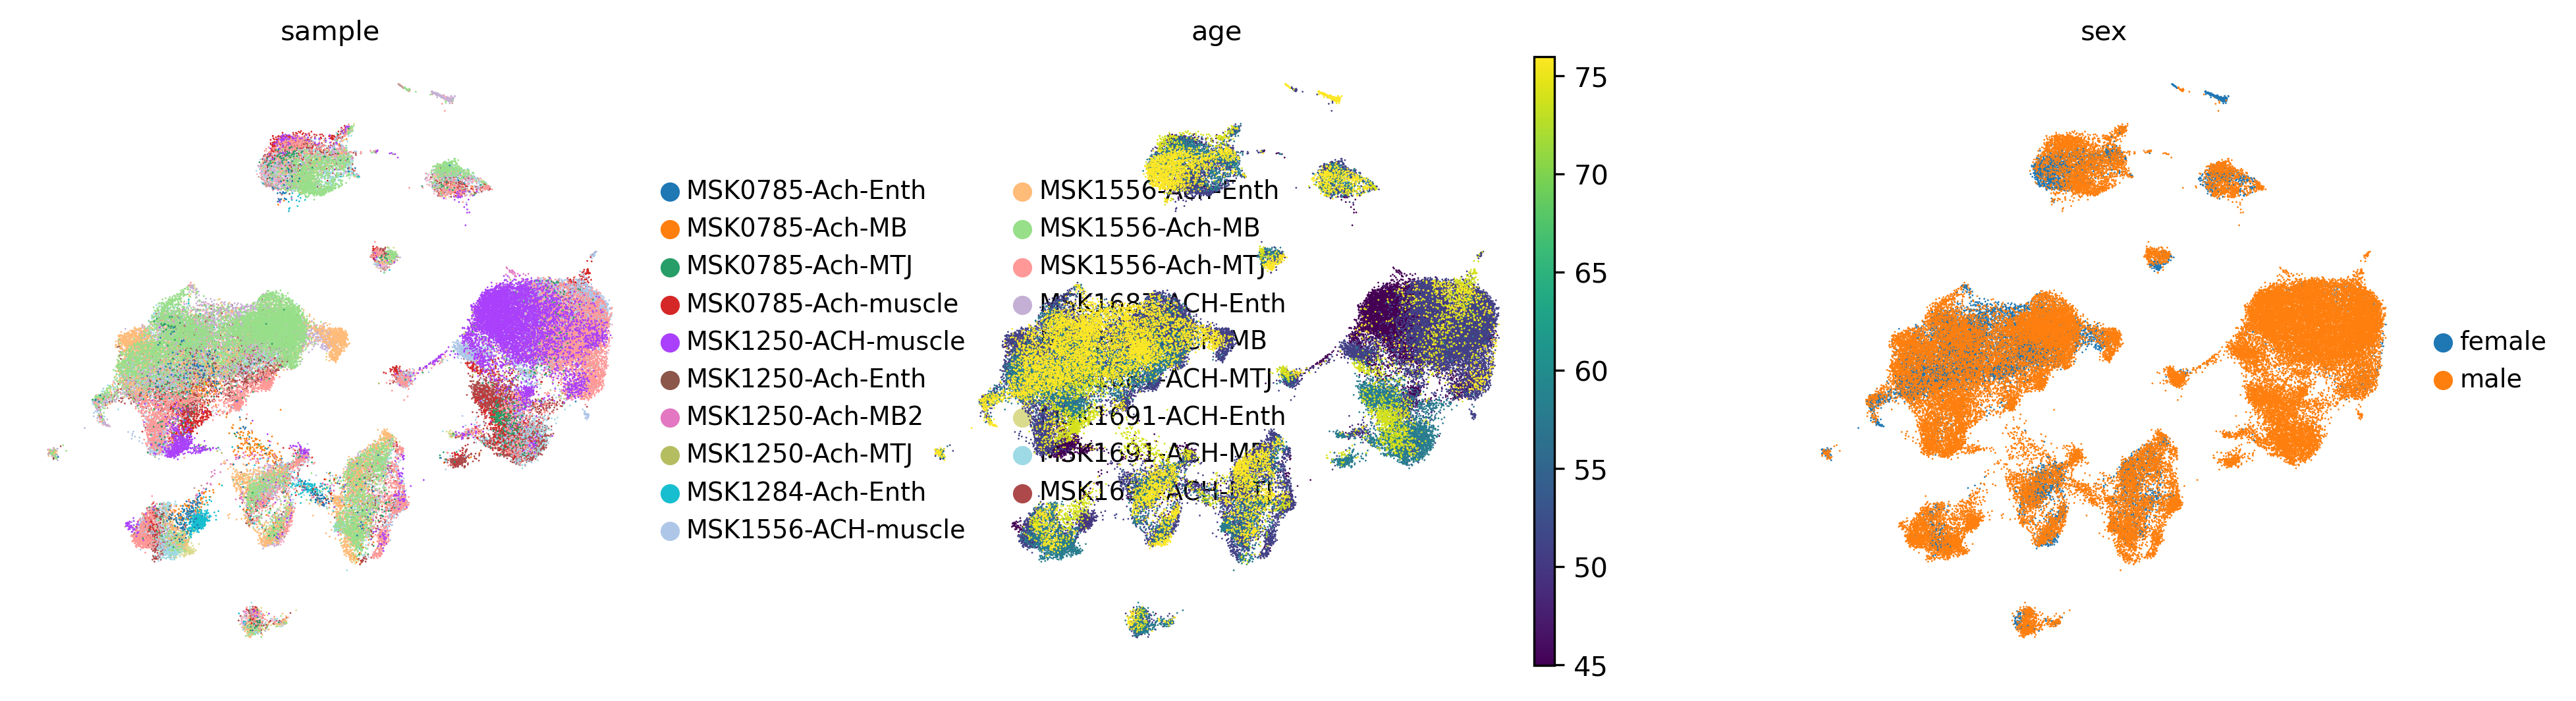

In [21]:
# Extract latent representation embeddings from your trained model 
# Use those to calculate the neighbours and UMAPs. Plot UMAPs of batch and ct markers.
adata_scvi.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata_scvi, use_rep="X_scVI", metric='correlation')
sc.tl.umap(adata_scvi)
sc.pl.umap(adata_scvi, color="sample")
sc.pl.umap(adata_scvi, color=["sample", "age", "sex"], 
           ncols=3, wspace=0.3,
           frameon=False)

/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


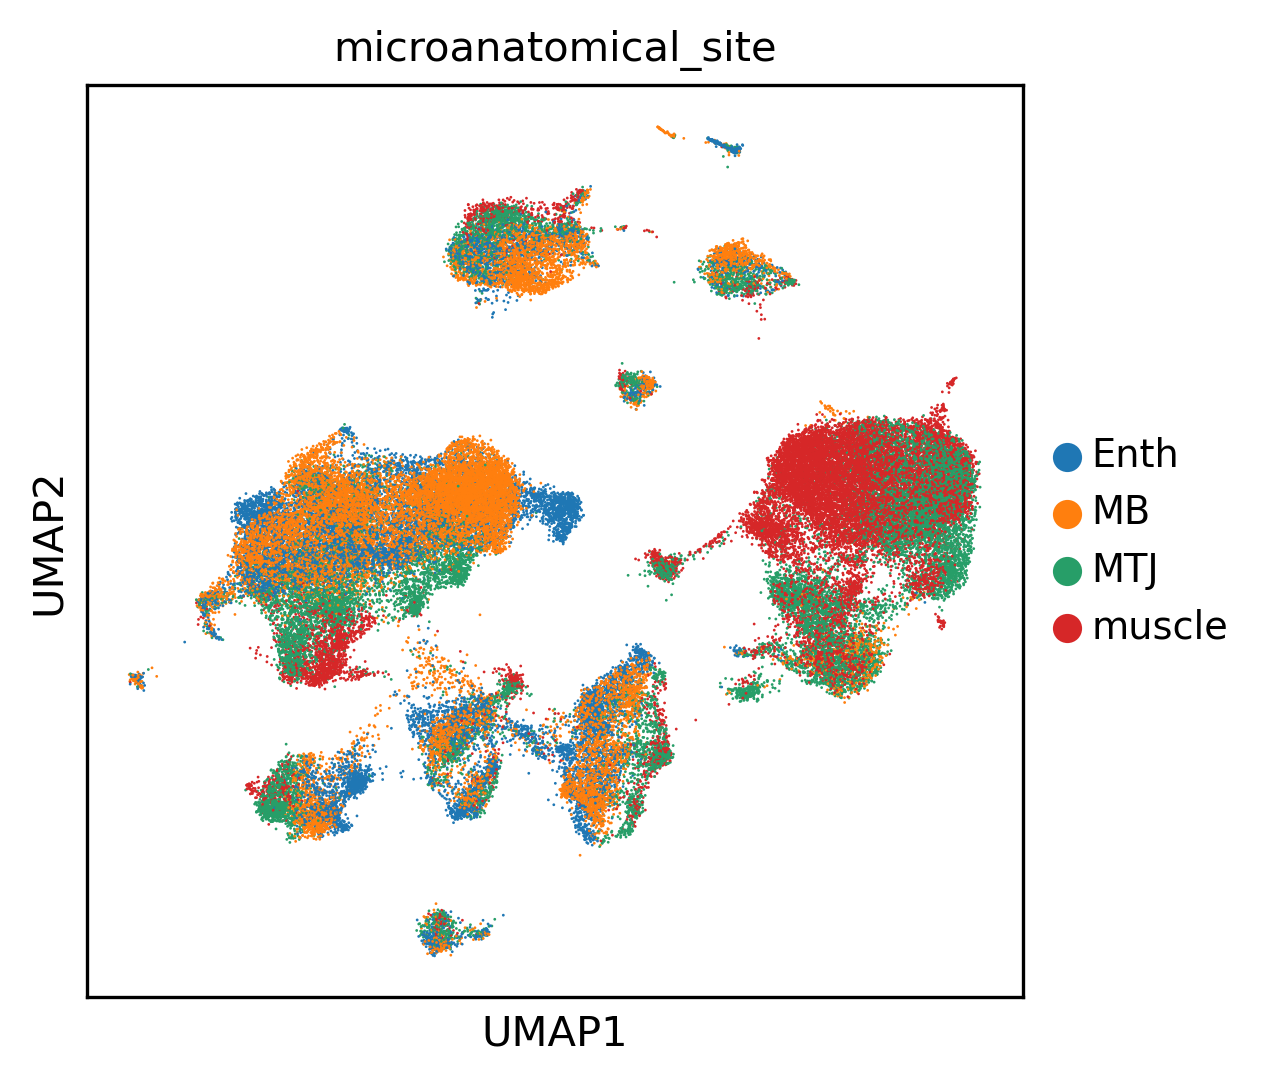

In [22]:
sc.pl.umap(adata_scvi, color="microanatomical_site")

/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


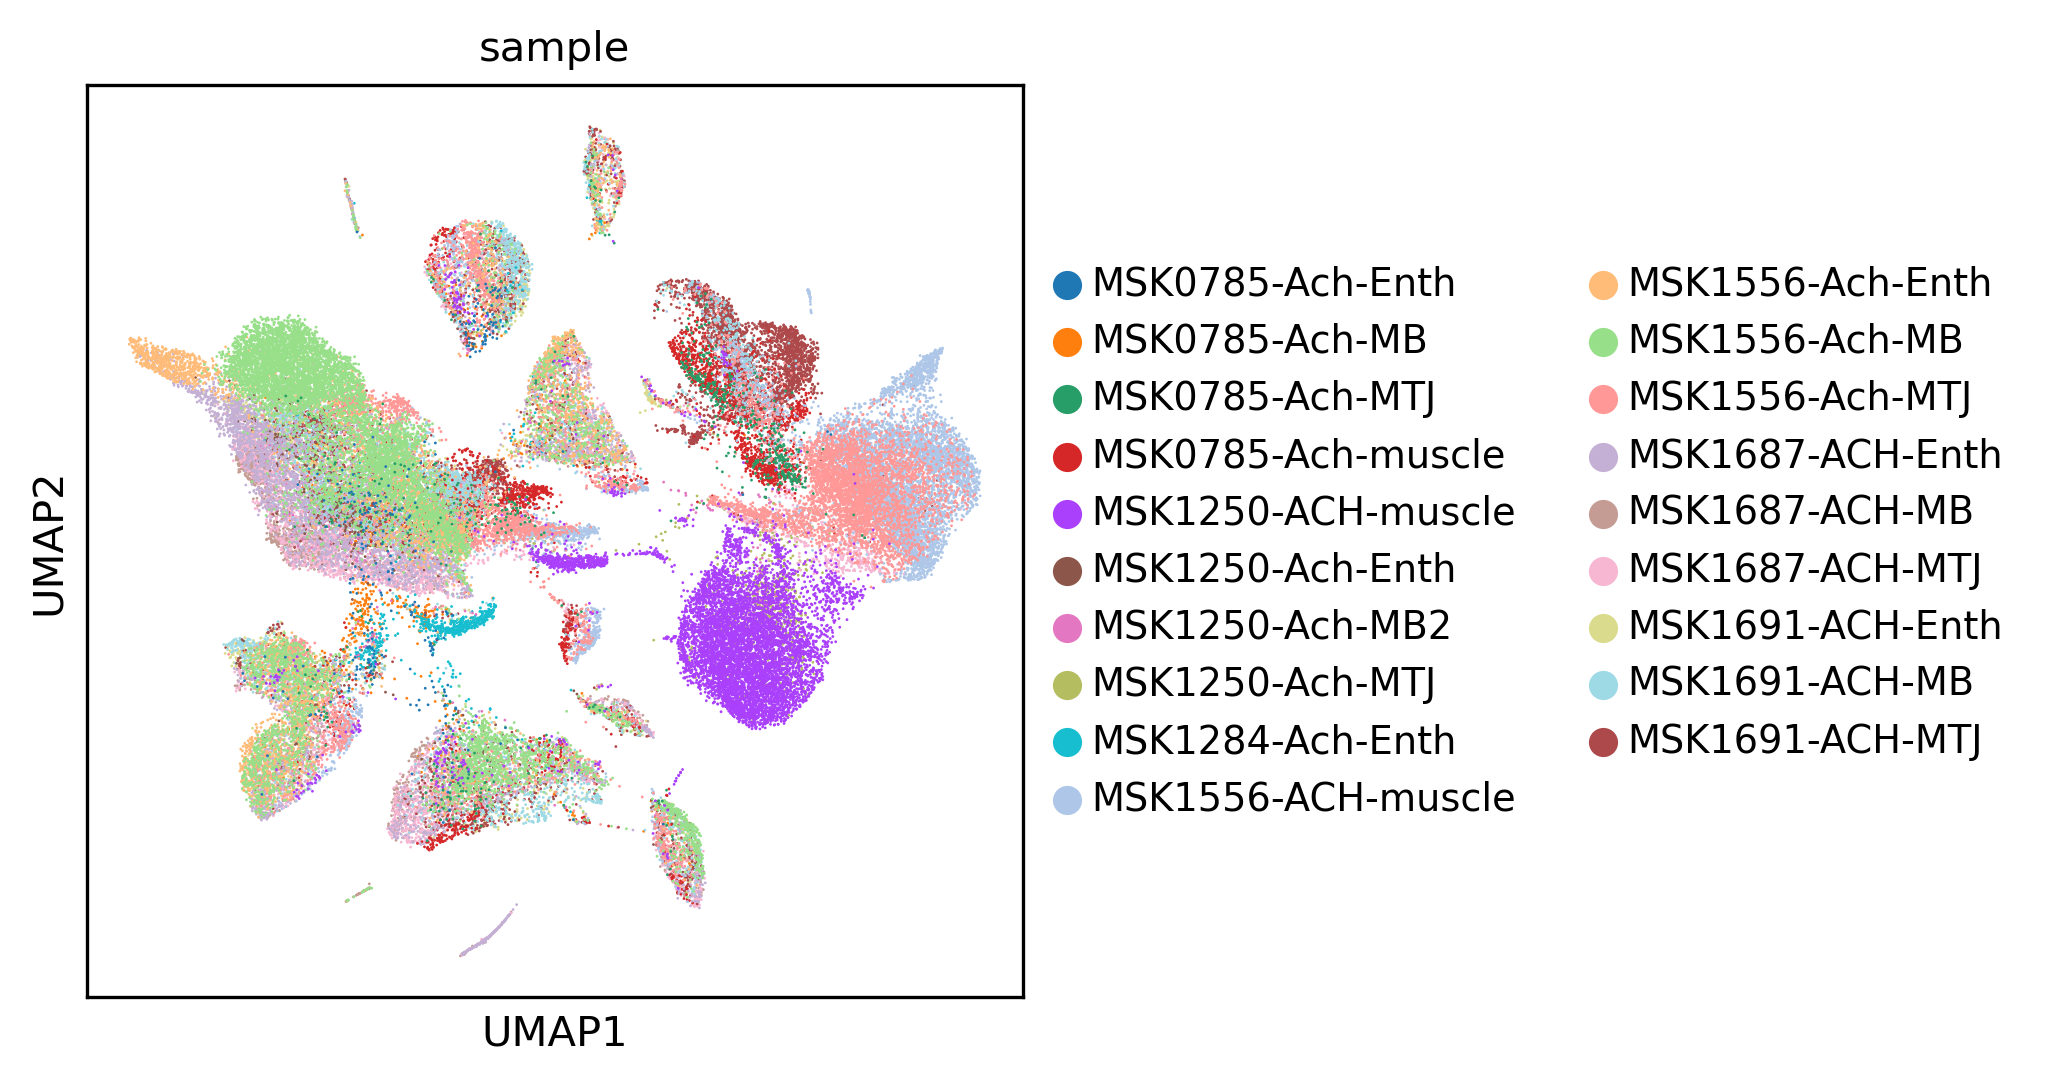

/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the 

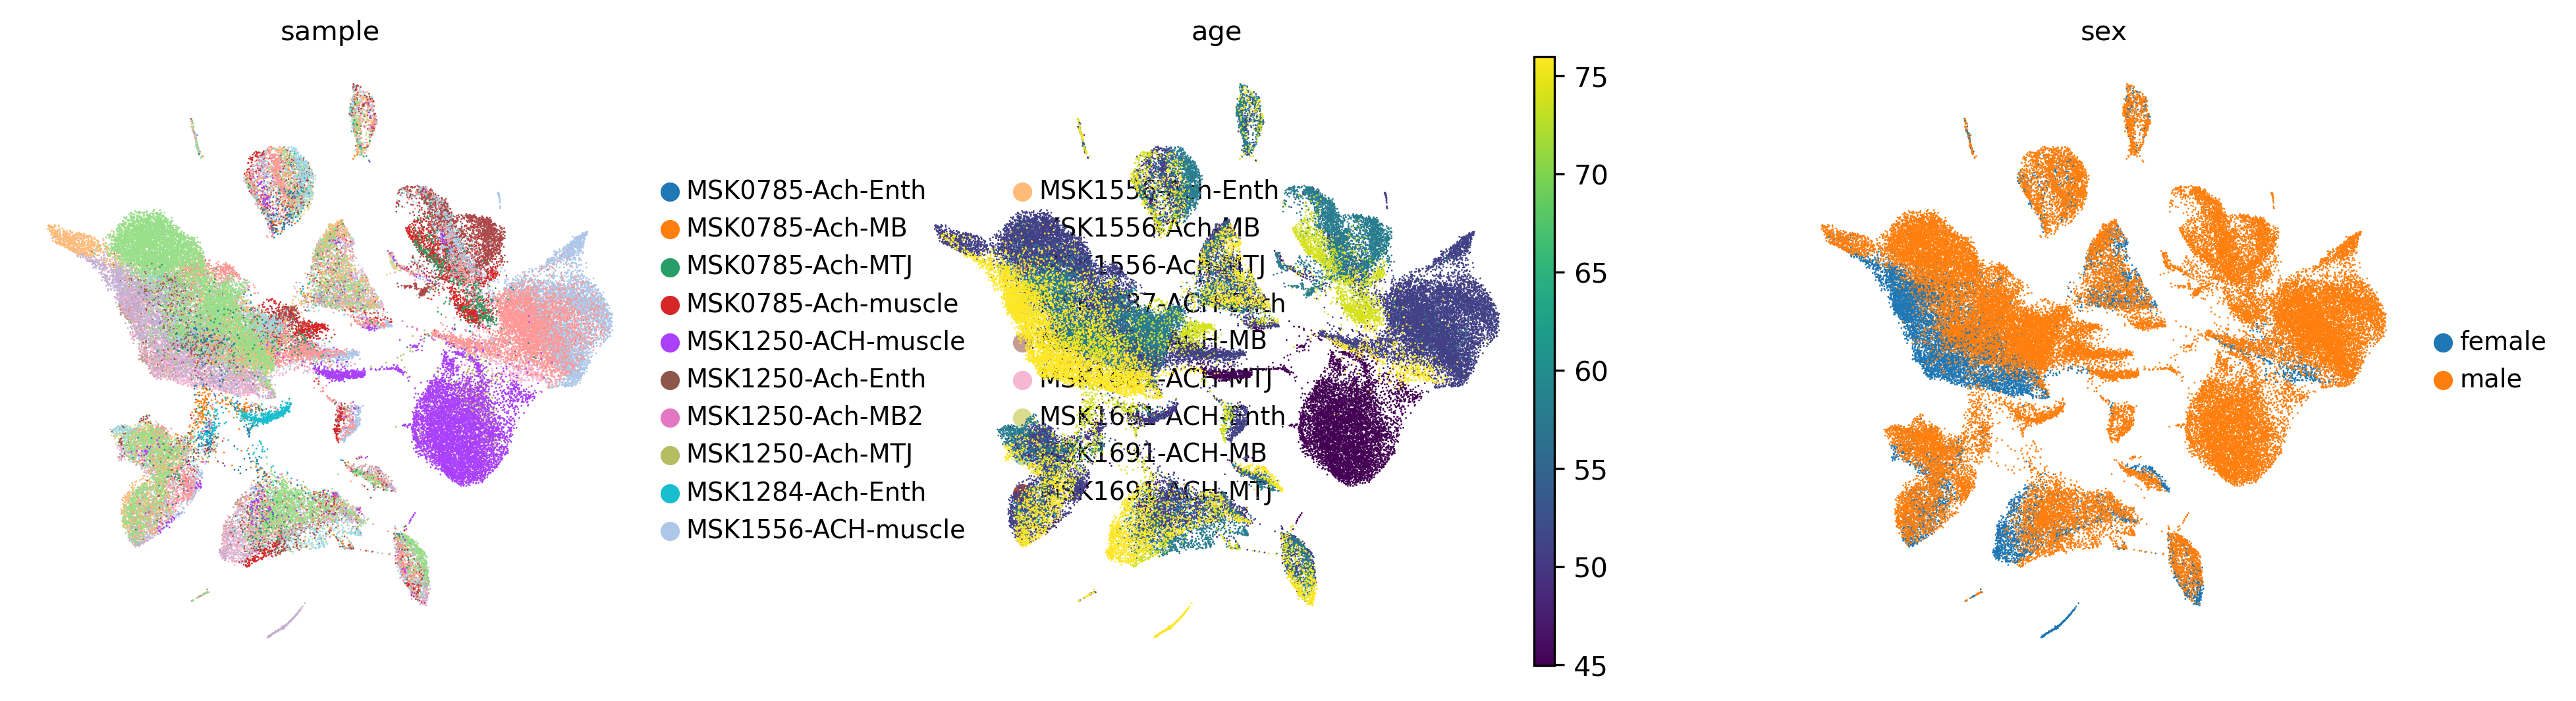

In [23]:
# plot the UMAP before integration
sc.pl.umap(adata_ref, color="sample")
sc.pl.umap(adata_ref, color=["sample", "age", "sex"], 
           ncols=3, wspace=0.3,
           frameon=False)

/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


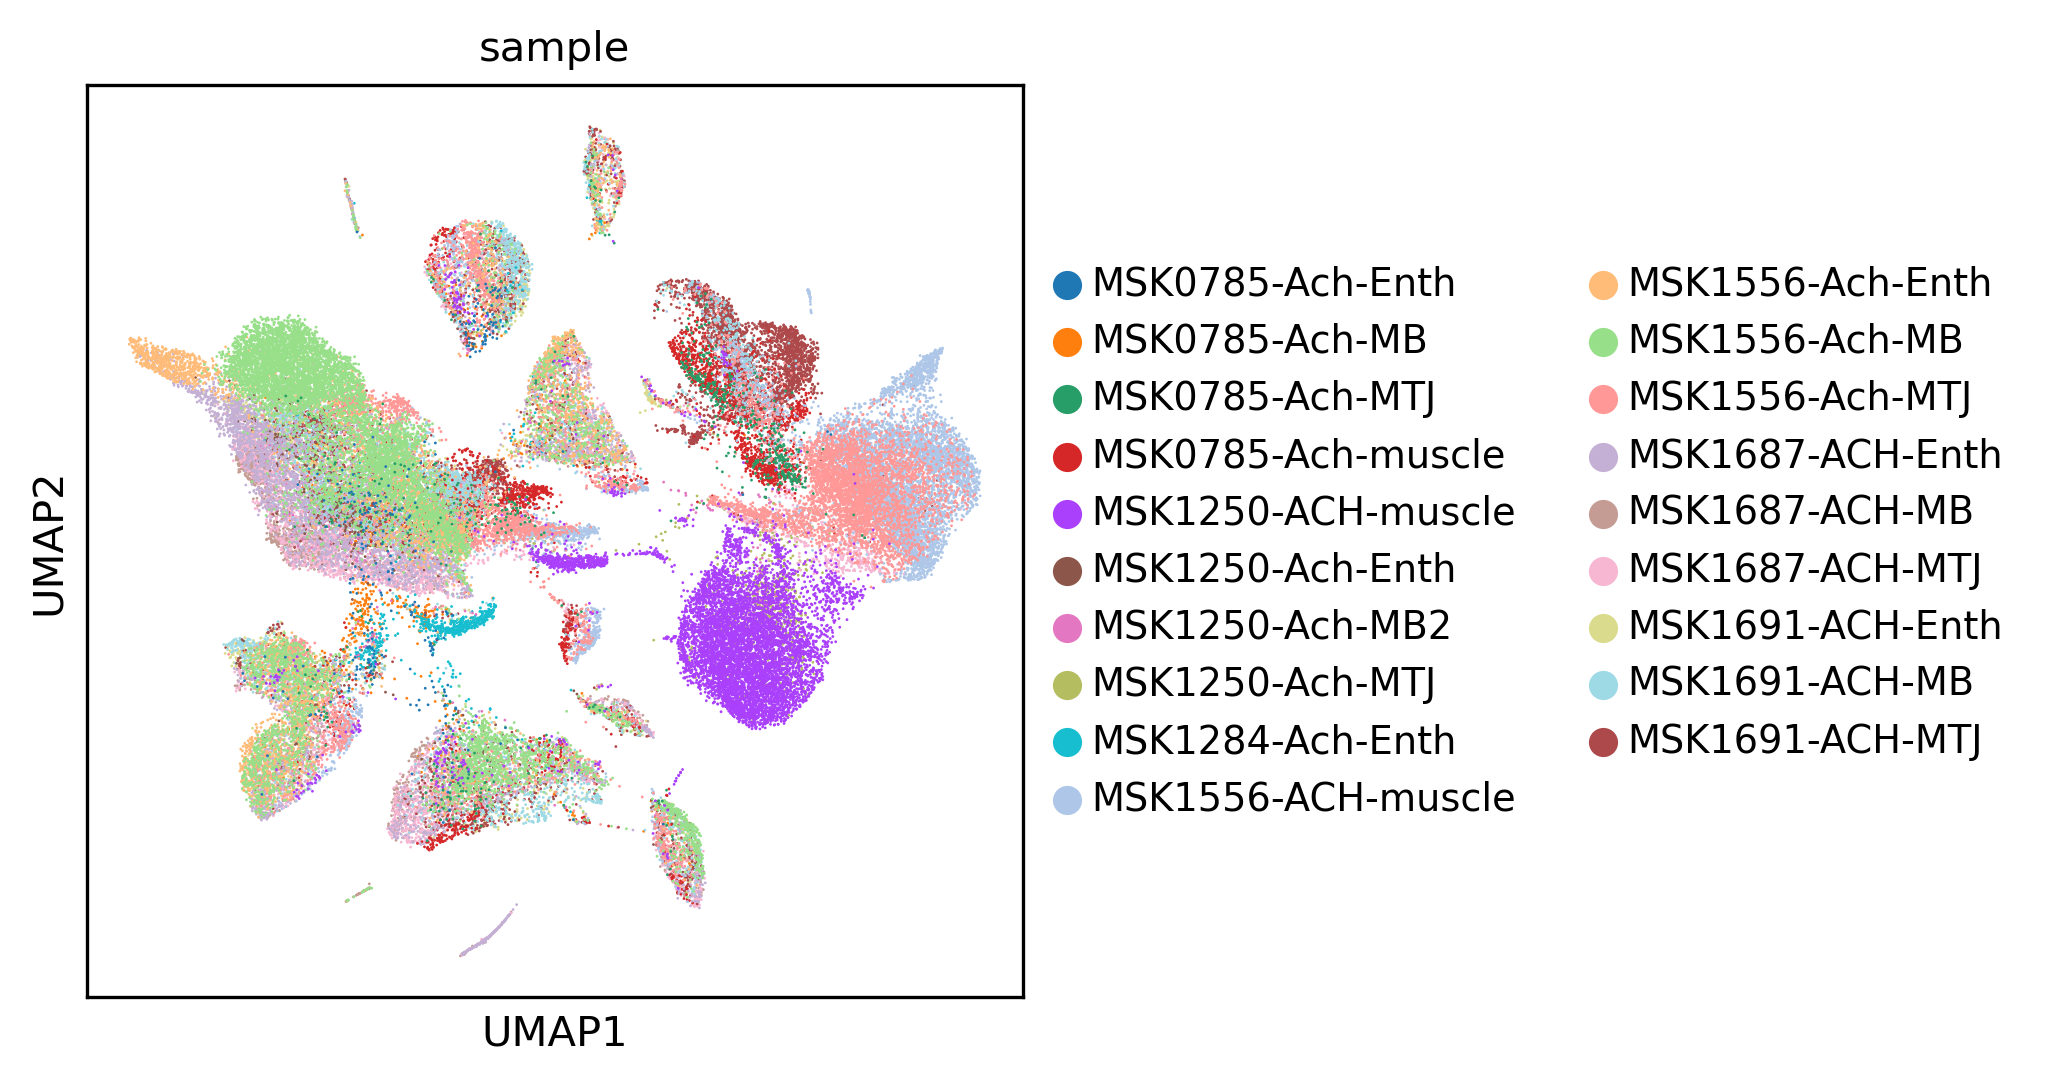

/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/media/prom/apc1/ccohen/mamba_installation/conda/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


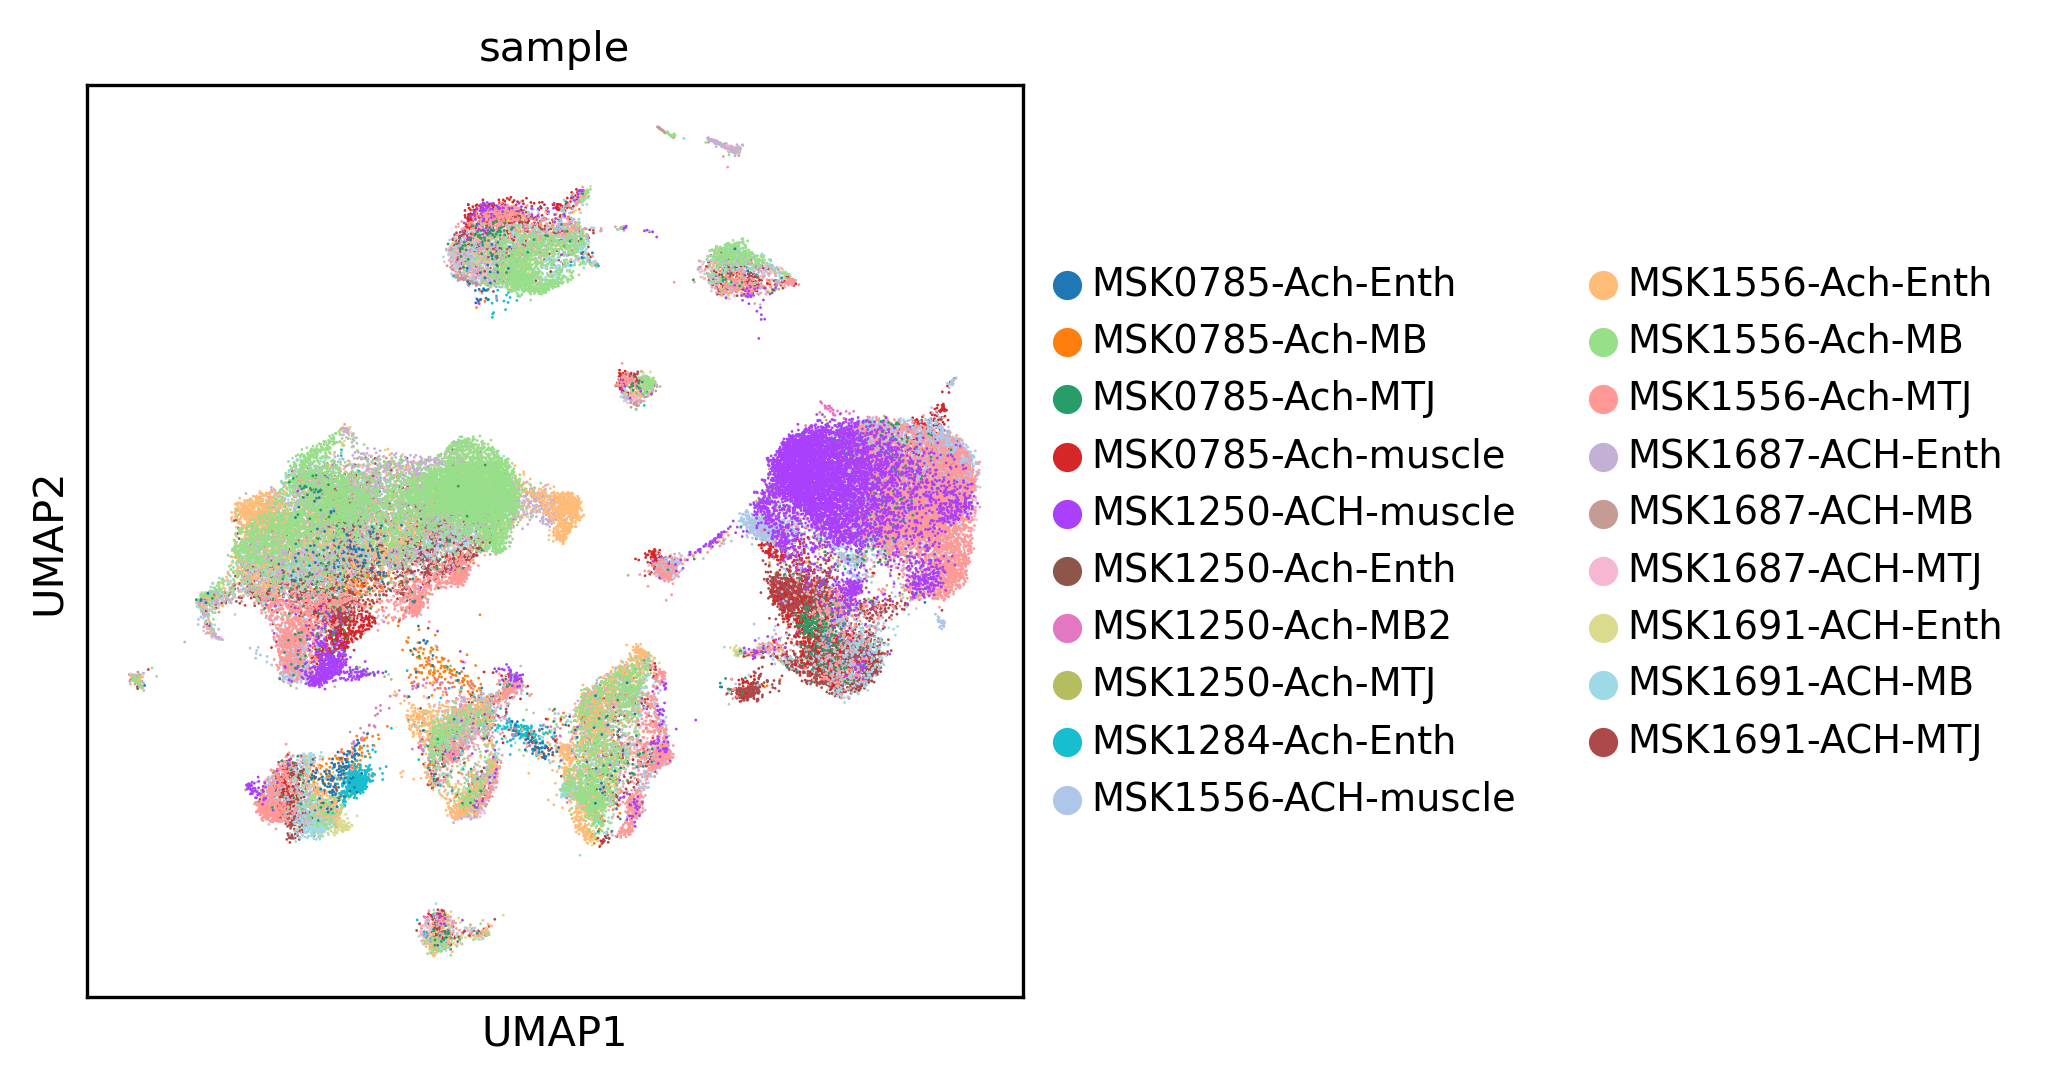

In [24]:
# plot unintegrated and integrated side by side
sc.pl.umap(adata_ref, color="sample")
sc.pl.umap(adata_scvi, color="sample")

In [25]:
# save the object
adata_scvi.write(os.path.join(RESULTS_FOLDERNAME, 'Achilles_scVI.h5ad'))

In [26]:
adata_scvi.obsm['X_scVI']

array([[ 1.9645667 , -1.0750045 , -0.98173946, ...,  0.34883863,
        -3.0375774 , -0.13203235],
       [-0.3268004 ,  0.01119521,  1.5830088 , ...,  1.2161382 ,
         0.92941546,  0.8227843 ],
       [-1.0079646 ,  0.63842773,  0.73575747, ..., -0.08952999,
         0.871135  , -0.2760107 ],
       ...,
       [-0.3785209 ,  0.3759006 ,  0.42802262, ..., -0.2556702 ,
         0.26390636, -1.0121298 ],
       [-0.51908916,  0.1194438 ,  0.6794899 , ..., -0.45325184,
         0.42122954,  0.22519411],
       [-0.44087487,  3.0640101 , -0.4107327 , ...,  0.30237907,
        -0.74328715,  0.55847275]], dtype=float32)

In [27]:
adata_scvi.uns['pca']['variance']

array([131.61836632,  60.03510255,  49.76707089,  38.68839511,
        26.65868838,  25.00521411,  22.43684419,  19.5718154 ,
        17.18036164,  14.84709878,  14.27573588,  13.08343109,
        10.78532296,  10.21323048,   9.46648255,   8.37471303,
         8.19626844,   7.33252924,   7.27218019,   6.90642092,
         6.68040572,   6.51428347,   6.27753149,   5.91981918,
         5.64492623,   5.25223192,   5.1424982 ,   5.05064861,
         4.91876934,   4.84437073,   4.65270556,   4.51888404,
         4.28400414,   4.20545835,   4.07458528,   4.02231963,
         3.77894611,   3.71691053,   3.695793  ,   3.62976295])

Save the scVI embeddings as numpy array

In [28]:
filename = RESULTS_FOLDERNAME + "scVI_embeddings"
filename

'20240829_11-56_integration-scvi.dir/results/scVI_embeddings'

In [29]:
np.save(filename, adata_scvi.obsm['X_scVI'])